# Часть 1: Формулировка ML-задачи и выбор модели

## 1. Бизнес-цели и метрики

Прежде чем углубляться в ML, зафиксируем бизнес-контекст. Основная цель — повысить доверие пользователей к платформе (Trust & Safety) и оптимизировать операционные расходы.

**Ключевые бизнес-метрики:**

1.  **Reduction in Moderation Cost (Снижение затрат на модерацию):**
    * *Цель:* Автоматизировать 90%+ решений. Уменьшить количество отзывов, требующих ручной проверки модераторами-людьми.
2.  **Conversion Rate Impact (Влияние на конверсию):**
    * *Цель:* Увеличение конверсии в покупку на страницах товаров. (Гипотеза: пользователи, доверяющие отзывам, покупают чаще; наличие очевидного спама снижает конверсию).
3.  **User Retention (Удержание пользователей):**
    * *Цель:* Снижение оттока (Churn Rate) среди пользователей, которые пишут отзывы (честные авторы уходят, если видят, что платформу наводнили боты).

---

## 2. Определение ML-задачи

### Формулировка задачи
Задача формулируется как **бинарная классификация (Binary Classification)**.
Для каждого поступающего отзыва $x$ модель должна предсказать вероятность того, что он является фейковым: $P(y=1 | x)$, где $y=1$ — фейк/спам, $y=0$ — реальный отзыв.

*Примечание:* Также возможен подход *Anomaly Detection* (поиск аномалий), но в условиях наличия размеченных данных (от модераторов) классификация даст более точный и интерпретируемый результат.

### Таргет (Целевая переменная)
Целевая переменная $y$ бинарна:
* **1 (Positive):** Фейковый отзыв (накрутка рейтинга, спам, отзыв конкурента, сгенерированный текст без покупки).
* **0 (Negative):** Подлинный отзыв реального пользователя.

**Источник разметки (Ground Truth):**
* Исторические логи ручной модерации.
* Жалобы пользователей ("Report this review").
* Эвристики (например, отзывы с IP-адресов известных бот-ферм).

### Необходимые данные (Feature Engineering)
Учитывая требование анализировать текст, поведение и графы, нам понадобятся три группы признаков:

1.  **Текстовые признаки (Text Features):**
    * Raw Text: Сам текст отзыва.
    * NLP-метаданные: Длина текста, наличие капса, обилие эмодзи, sentiment score (слишком восторженные или агрессивные), повторяющиеся n-граммы (copy-paste).
    * Embeddings: Векторные представления текста (из BERT/RoBERTa) для улавливания семантики "рекламного" языка.

2.  **Поведенческие признаки пользователя (User Behavior):**
    * User Tenure: Возраст аккаунта.
    * Velocity: Количество отзывов, оставленных за последний час/день (RPS пользователя).
    * Review Distribution: Средняя оценка пользователя (если у пользователя 100% отзывов — это 5 звезд, это подозрительно).
    * Verified Purchase: Был ли куплен товар через платформу.
    * Device/IP Fingerprints: Смена User-Agent, использование VPN/Proxy.

3.  **Графовые признаки (Graph Features):**
    * Связи User-Item-IP.
    * *Co-review graph:* Признаки, указывающие на сговор (группа пользователей $A, B, C$ всегда комментирует одни и те же товары $X, Y, Z$ в одно и то же время).
    * Компоненты связности: Размер кластера, к которому принадлежит пользователь.

---

## 3. Выбор модели

Учитывая высокую нагрузку (**16,370 RPS**) и жесткий SLA (**435 ms**), выбор модели — это компромисс между точностью и скоростью.

### Вариант 1: Гибридная нейросеть (Fine-tuned DistilBERT + Dense Layers)
Архитектура, где текстовая часть обрабатывается легковесным трансформером, а выходной вектор конкатенируется с метаданными (поведение + граф) и подается в полносвязные слои.

* **Преимущества:**
    * SOTA (State-of-the-Art) качество анализа текста. Отлично ловит смысловые паттерны фейков (например, GPT-generated отзывы).
    * End-to-end обучение (текст и фичи обучаются вместе).
* **Недостатки:**
    * **Latency & Compute:** Обработка трансформером на каждом из 16k запросов в секунду требует огромного кластера GPU. Уложиться в 435 мс можно, но это будет очень дорого.
    * Сложнее интерпретировать, чем деревья.

### Вариант 2: Градиентный бустинг (CatBoost / XGBoost)
Классическое решение для индустрии. На вход подаются поведенческие фичи, графовые метрики (предварительно посчитанные) и текстовые эмбеддинги (как готовые векторы).

* **Преимущества:**
    * **Скорость:** Inference time измеряется миллисекундами даже на CPU. Легко держит 16k RPS.
    * **Работа с табличными данными:** Лучше всех работает с категориальными признаками (ID товара, категории) и счетчиками поведения.
    * **Интерпретируемость:** Легко получить Feature Importance (понять, почему отзыв забанен).
* **Недостатки:**
    * Сам по себе не "читает" текст. Требует отдельного этапа генерации эмбеддингов (через быстрый NLP-сервис).

### Вариант 3: Graph Neural Network (GNN - например, GraphSAGE)
Модель, обучаемая непосредственно на графе взаимодействий User-Item.

* **Преимущества:**
    * Идеально для обнаружения "колец ботов" и сложных схем накрутки, которые не видны на уровне одного отзыва.
* **Недостатки:**
    * Сложность внедрения в Real-time (inductive learning). Сбор соседей (neighbor sampling) при инференсе может создавать большую задержку.

---

### Финальный выбор для проектирования

Я выбираю **Вариант 2: Градиентный бустинг (CatBoost)**, усиленный признаками из других моделей.

**Обоснование выбора:**
1.  **Нагрузка (16,370 RPS):** Это очень высокий RPS. Чистый BERT или GNN в реал-тайме потребуют неоправданно дорогой инфраструктуры. CatBoost эффективен и быстр.
2.  **Природа данных:** Фейковые отзывы часто выдают себя не текстом (текст может быть идеальным), а метаданными (IP, тайминги, отсутствие покупки). Бустинг здесь король.
3.  **Гибридный подход (Stacking):**
    * *Текст:* Мы будем использовать легковесную NLP-модель (например, FastText или дистиллированный BERT в виде микросервиса) для получения вектора текста, который пойдет как *feature* в CatBoost.
    * *Графы:* Мы будем использовать GNN в оффлайн-режиме (batch) для расчета `risk_score` пользователя на основе его связей, и передавать этот скор в CatBoost как фичу.

**Итоговая модель:** CatBoost Classifier.
**Входные данные:** User features + Behavioral counters + Text Embeddings (pre-calculated) + Graph Scores (pre-calculated).

# Часть 2: Проектирование архитектуры

## 1\. Высокоуровневая архитектура (High-Level Design)

Система строится по принципу микросервисов. Основной поток блокировки фейков работает в реальном времени (Synchronous Flow), чтобы предотвратить публикацию спама. Тяжелые вычисления (обновление графов, глубокий анализ) вынесены в асинхронный контур.

### Основные компоненты:

  * **Review Service:** Бэкенд, принимающий отзывы от пользователей.
  * **Anti-Fake Gateway (ML Service):** Единая точка входа для проверки контента.
  * **Feature Store:** Центральное хранилище признаков (разделенное на Online и Offline).
  * **Message Queue (Kafka):** Шина данных для асинхронной обработки.

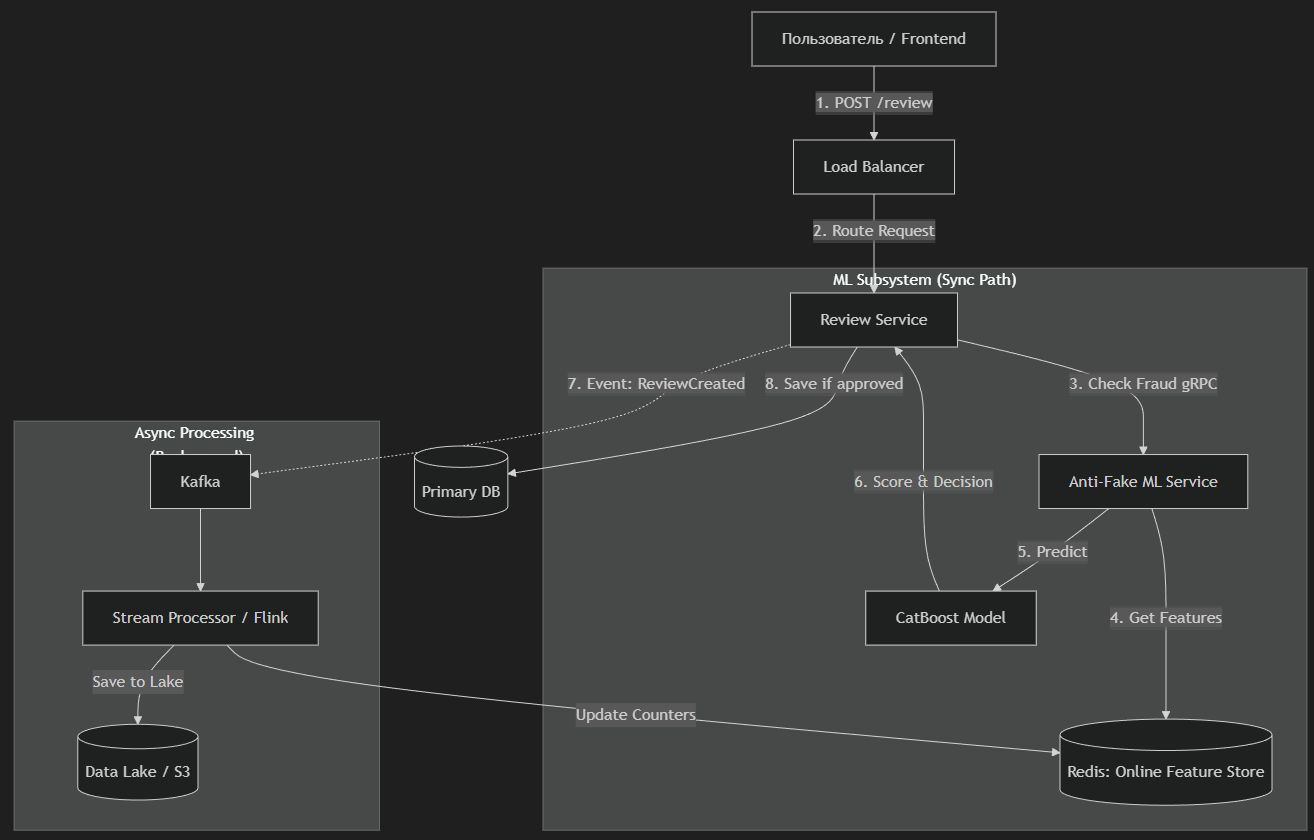

-----

## 2\. Архитектура Data Pipeline

Для обеспечения низкой задержки и актуальности данных используется **Lambda-архитектура** (или Kappa), разделяющая потоковую и пакетную обработку.

**Ключевая проблема:** Как подать в модель информацию о том, что пользователь оставил 50 отзывов за последние 10 минут?
**Решение:** Stream Processing (Flink/Spark Streaming).

### Поток данных:

1.  **Batch Layer (Холодные данные):** Исторические логи, графовые связи, разметка модераторов. Используется для обучения модели.
2.  **Speed Layer (Горячие данные):** События в реальном времени (клики, новые отзывы). Используется для подсчета счетчиков (Velocity features) и записи их в Redis.

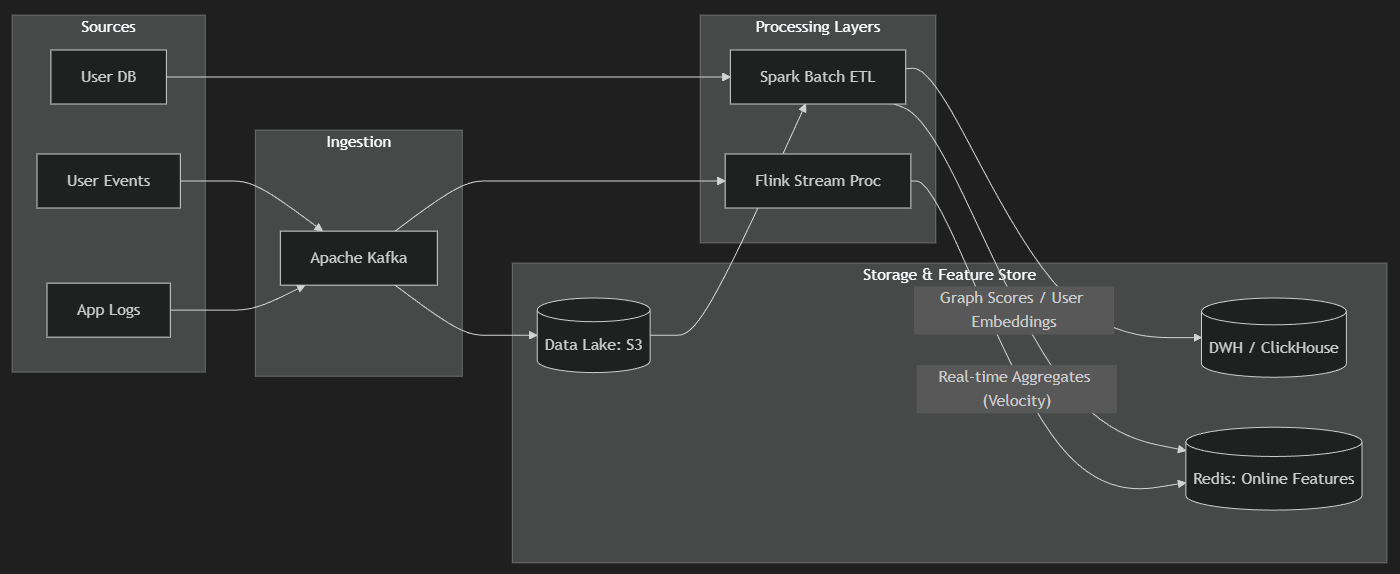

-----

## 3\. Архитектура Training Pipeline

Обучение происходит оффлайн по расписанию (например, раз в неделю) или при деградации метрик.

**Особенности:**

  * Использование **Feature Store** как единственного источника правды (чтобы фичи на трейне совпадали с фичами на инференсе).
  * **Graph Pre-processing:** Перед обучением CatBoost запускается алгоритм (например, Louvain community detection) для расчета графовых скоров.

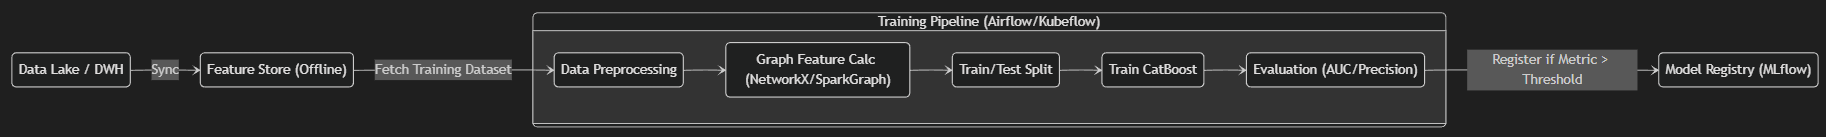

-----

## 4\. Архитектура Inference Pipeline (Serving)

Самая критичная часть. Нам нужно уложиться в **435 мс** при **16k RPS**.

**Стратегия оптимизации задержки:**

1.  **Предвычисления (Pre-computation):** Графовые скоры и сложные поведенческие метрики уже лежат в Redis. Мы их просто читаем ($< 5$ мс).
2.  **Текст:** Легковесная токенизация и инференс текстовой модели (например, дистиллированный BERT через ONNX Runtime или FastText).
3.  **Модель:** CatBoost очень быстр на CPU.
4.  **Скейлинг:** Kubernetes HPA (Horizontal Pod Autoscaler) добавляет поды при росте CPU/RPS.

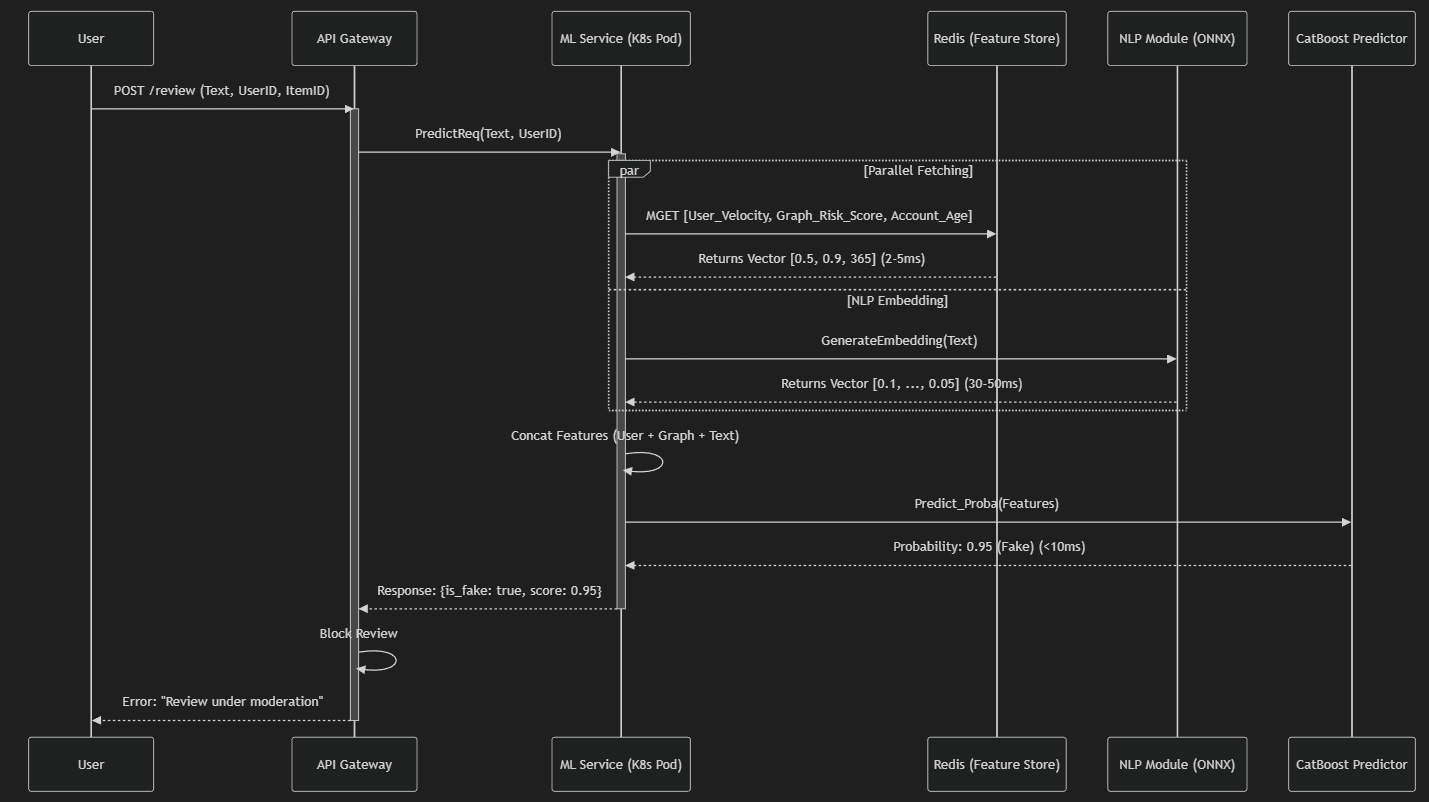

-----

### Комментарий к схемам для отчета:

При реализации этой архитектуры достигается баланс между сложностью и скоростью:

1.  **Online Feature Store (Redis):** Обеспечивает мгновенный доступ к "медленным" данным (графовые связи), которые были посчитаны заранее. Это разгружает Real-time пайплайн.
2.  **Асинхронность:** Мы не пересчитываем граф при каждом запросе.
3.  **ONNX/TensorRT:** Использование оптимизированных ранфтаймов для текстовой части критически важно для соблюдения SLA 435 мс.

# Часть 3: Расчёты и нефункциональные требования

## 1. Расчёт требований к пропускной способности (Throughput)

### 1.1. Расчёт требуемого количества серверов (Inference Service)

**Дано:**
* Пиковая нагрузка: $RPS_{peak} = 16,370$ запросов в секунду.
* Допустимая задержка (SLA): $L = 435$ мс.
* Целевая утилизация CPU: $U_{target} = 70\%$ (оставляем запас для всплесков).
* Предполагаемая производительность одного ядра: $RPS_{core} \approx 200 - 300$ (для CatBoost + Redis Lookups + легкий NLP). Возьмем консервативное значение: $RPS_{core} = 250$.

**Расчёт общего требуемого количества ядер:**
$$Cores_{required} = \frac{RPS_{peak}}{RPS_{core} \times U_{target}}$$
$$Cores_{required} = \frac{16,370}{250 \times 0.70} \approx \frac{16,370}{175} \approx 93.5 \text{ ядер}$$

**Вывод:** Для обслуживания пиковой нагрузки нам потребуется минимальный кластер, эквивалентный **94 ядрам CPU** (предполагая высокопроизводительные инстансы, например, 8-ядерные).

* Если использовать **8-ядерные** инстансы: $\lceil 94 / 8 \rceil = 12$ серверов.
* Если использовать **16-ядерные** инстансы: $\lceil 94 / 16 \rceil = 6$ серверов.

**Рекомендация:** Развернуть **7-8 инстансов** (для запаса и отказоустойчивости) CatBoost ML Service с 16 ядрами каждый, используя Kubernetes HPA для автоматического масштабирования.

### 1.2. Расчёт задержки (Latency Budget)

Проверим, как распределяется SLA в 435 мс по архитектуре:

| Этап | Компонент | Примерная задержка | Обоснование |
| :--- | :--- | :--- | :--- |
| **1.** Сеть / LB | Load Balancer / API Gateway | 10 мс | Сетевые накладные расходы |
| **2.** Сбор признаков | Online Feature Store (Redis) | 5 - 10 мс | Одно чтение/запись по ключу |
| **3.** Текстовые признаки | NLP Service (ONNX/FastText) | 30 - 60 мс | Легковесный инференс (самый долгий этап) |
| **4.** Инференс модели | CatBoost Predictor | 5 - 15 мс | Быстрый алгоритм, инференс на CPU |
| **5.** Логирование/Ответ | Review Service/DB | 10 мс | Запись в лог, возврат ответа |
| **Итоговый P99** | **Сумма** | **~ 60 - 105 мс** | **Далеко ниже SLA (435 мс)** |

**Вывод:** Система CatBoost с предварительно рассчитанными признаками и выделенным NLP-модулем легко укладывается в требуемые **435 мс** даже при P99.

## 2. Расчёт требований к хранилищу (Feature Store)

**Цель:** Оценить размер Online Feature Store (Redis) для хранения оперативных признаков.

**Дано:**
* DAU: $3,598,581$ активных пользователей.
* Количество товаров: Пусть будет $1,000,000$ (типично для крупного e-commerce).
* Срок хранения поведенческих данных: 30 дней.

**Признаки для хранения (Feature Vectors):**

1.  **Признаки пользователя (User Features):**
    * Признаки: Возраст аккаунта, средний рейтинг, риск-скор (из GNN), счетчики активности за 1ч/1д/7д (всего $\approx 50$ признаков).
    * Размер одного вектора: $50 \times 4$ байта (Float) $\approx 200$ байт.
    * Общий объём для пользователей: $3.6M \text{ пользователей} \times 200 \text{ байт} \approx 720 \text{ МБ}$.

2.  **Эмбеддинги товаров (Item Embeddings):**
    * Эмбеддинг: 128-мерный вектор.
    * Размер: $128 \times 4$ байта (Float) $\approx 512$ байт.
    * Общий объём для товаров: $1M \text{ товаров} \times 512 \text{ байт} \approx 512 \text{ МБ}$.

3.  **Горячие счетчики (Hot/Time-series Features):**
    * Хранение тайм-серии для каждого пользователя (например, последние 10 действий).
    * Объём: $\approx 500 \text{ МБ}$.

**Итоговый объём Online Feature Store (Redis):**
$$V_{total} \approx 720 \text{ МБ} + 512 \text{ МБ} + 500 \text{ МБ} \approx 1.73 \text{ ГБ}$$

**Вывод:** Требования к хранилищу для горячих данных крайне низкие (менее **2 ГБ**). Это подтверждает, что **Redis Cluster** (или эквивалент) отлично подходит для **Online Feature Store** с минимальными операционными расходами.

## 3. Масштабируемость и надёжность (Scalability and Reliability)

### Масштабируемость (Scalability)
* **Горизонтальное масштабирование (Horizontal Scaling):**
    * **ML Service:** Легко масштабируется через Kubernetes (K8s) и HPA (Horizontal Pod Autoscaler), так как инстансы без состояния (stateless). При росте RPS K8s автоматически добавит инстансы, чтобы утилизация CPU не превысила 70%.
    * **Kafka:** Обеспечивает масштабируемость Data Pipeline, позволяя обрабатывать растущий объем событий без потери данных.
* **Модульность:** Архитектура на микросервисах позволяет независимо масштабировать самый медленный компонент (NLP Module) и самый нагруженный (CatBoost Service).

### Надёжность (Reliability)
* **Отказоустойчивость (Fault Tolerance):**
    * Все ключевые компоненты (Kafka, Redis, K8s, DB) развертываются в **кластерной конфигурации** с репликацией между минимум **тремя зонами доступности (AZs)**.
    * **Model Rollback:** Использование **Model Registry (MLflow)** позволяет мгновенно откатить модель до предыдущей версии, если новая модель вызывает деградацию метрик или ошибки.
* **Мониторинг:**
    * Настройка сквозного мониторинга задержки (Latency P99) и бизнес-метрик (False Positive Rate, False Negative Rate) в реальном времени.
    * Автоматические алерты при превышении 400 мс задержки или 80% утилизации CPU.

## Заключение по НФТ

Система, основанная на гибридной архитектуре CatBoost + Feature Store, демонстрирует высокую производительность и масштабируемость. Она **с запасом укладывается** в требуемую задержку (**435 мс**) и способна обрабатывать пиковую нагрузку в **16,370 RPS** за счет эффективного использования CPU и предварительного вычисления сложных признаков (графов) в оффлайн-режиме.